In [1]:
import argparse
import configparser
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bts.models.data import Data, Sample
from bts.models.regression import BaseLineModel
from bts.models.kalman_filter import KalmanFilterChangePointModel
from bts.models.data import gaussian

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--dummy', nargs='?', default='None')
parser.add_argument('--last-n-days', nargs='?', default='30', type=int)
parser.add_argument('--num-samples', nargs='*', default=1000, type=int)
parser.add_argument('--num-burnin', nargs='*', default=5000, type=int)
parser.add_argument("-c", "--config", dest='config_file', default='config.ini', type=str)
args = parser.parse_args(args=['--dummy'])

config = configparser.ConfigParser()
config.read(args.config_file)
args.s3_bucket = config.get('default', 's3_bucket')
args.s3_prefix = config.get('default', 's3_prefix')

In [3]:
sample1 = Sample(N=50, mu=1440, beta=0.03, sigma=0.3)
sample2 = Sample(N=50, mu=1442, beta=0.1, sigma=0.5)
sample3 = Sample(N=50, mu=1440, beta=0.001, sigma=0.3)
sample = sample1 + sample2 + sample3

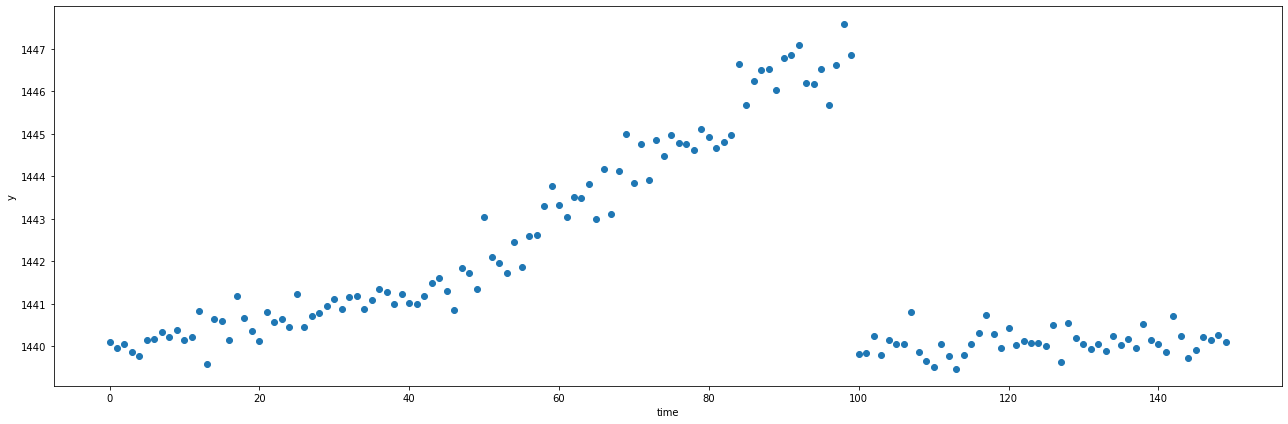

In [6]:
sample.plot()
zs = sample.y
ts = sample.t

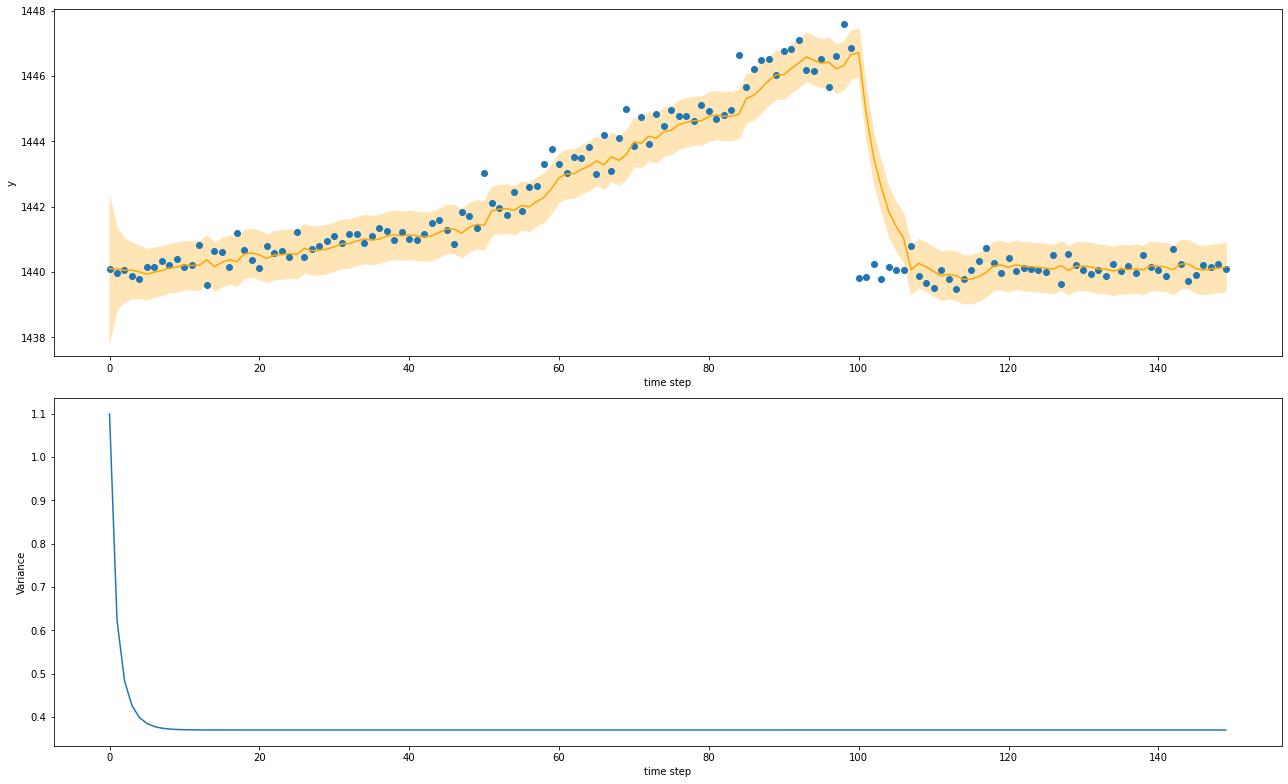

In [7]:
smoothing_param = 0.1
movement = gaussian(0, smoothing_param)
kf_model = KalmanFilterChangePointModel(changepoint_tolerance=5, residual_tolerance=0.5)
kf_model.fit(zs, movement, sensor_var=1)
kf_model.plot_all(ts, zs)

In [8]:
data = Data(args.s3_bucket, args.s3_prefix, args.last_n_days)
data.get_raw_generator()
data.preprocessing()

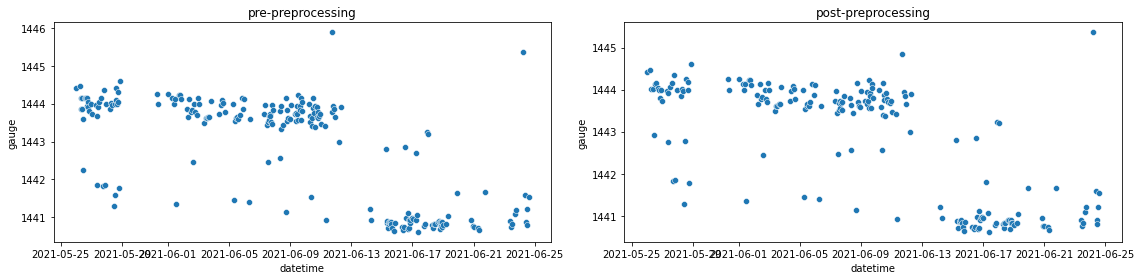

In [9]:
suspect = (9.65, 'Down')
target = 'gauge'
df = data.sub_df(*suspect, target)

sp_model = BaseLineModel.from_df(df=df, target=target, num_samples=args.num_samples, num_burnin=args.num_burnin)

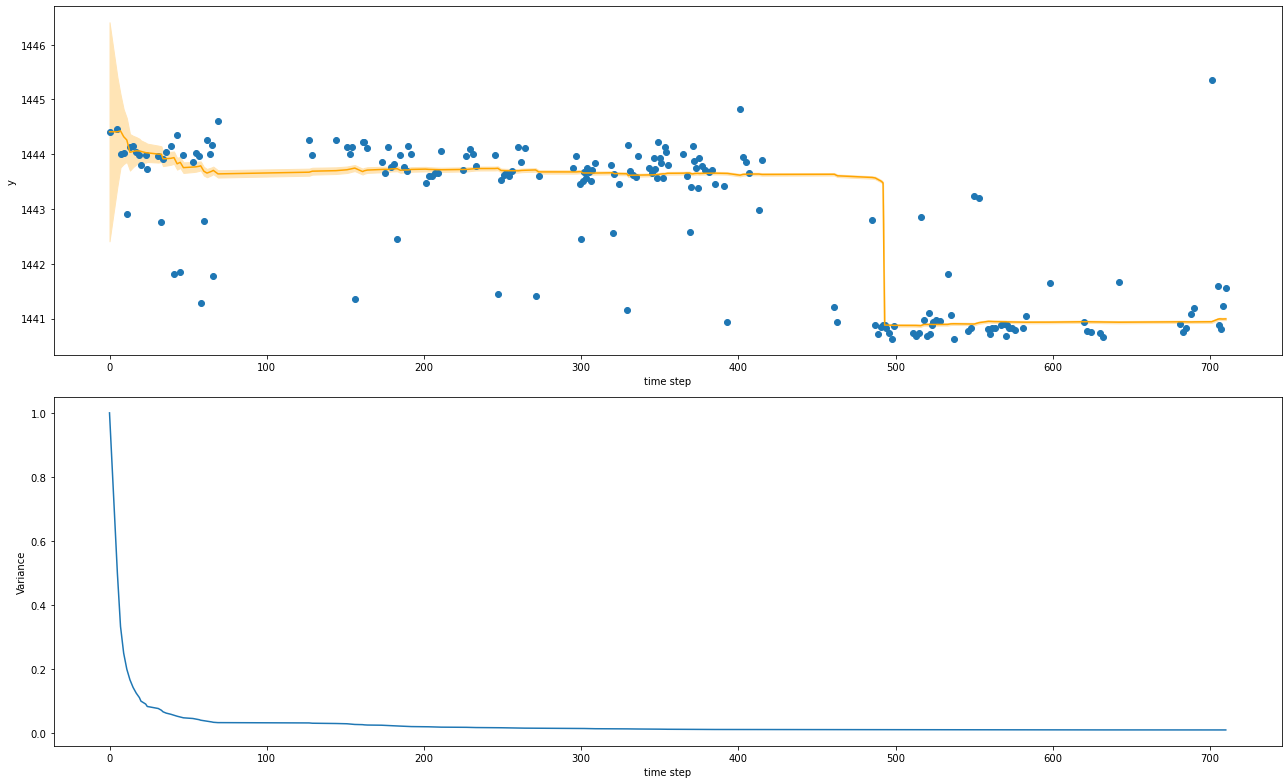

In [10]:
zs = sp_model.y
ts = sp_model.t
smoothing_param = 0.0001
movement = gaussian(0, smoothing_param)
kf_model = KalmanFilterChangePointModel(changepoint_tolerance=5, residual_tolerance=0.5)
kf_model.fit(zs, movement, sensor_var=1)
kf_model.plot_all(ts, zs)